In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import torch, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from untitled import SM_World, plot_SM, plot_raster, make_dataset_first_gm, tensor2spikeship,make_input_and_plot_sdist
from spikeship import spikeship
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.manifold import MDS, spectral_embedding, TSNE

In [18]:
N_trials = 10
N_coef_changes = 500
normalize_coef = True
mixture_only = True
plot = False # to plot the dissimilarity matrix given by SpikeShip

class world_params:
    N_pre = 100 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 3 # number of SM used for RP generation

    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM

    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP

    avg_precision = 10 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision

    seed = 4815162342 # seed


opt = world_params()
add_coef = torch.rand([opt.N_kernels])
world = SM_World(opt, add_coef = add_coef)
input_rp, labels, S_dist = make_input_and_plot_sdist(world, N_trials=N_trials, N_coef_changes=N_coef_changes, normalize_coef=normalize_coef, mixture_only=mixture_only, plot=plot)
input_flatten = input_rp.flatten(start_dim=1)

number_of_components=opt.N_kernels
print(f'Expected number of components {number_of_components-normalize_coef}')

 26%|████████████████████████████████████▋                                                                                                       | 1313/5010 [00:15<00:42, 85.99it/s]


KeyboardInterrupt: 

In [12]:
def plot_embedding(embedding, labels, title, colors=['r','g','b']):
    fig, ax = plt.subplots(figsize=(10,5))
    for l in np.unique(labels[:,-1]):
        indices = labels[:,-1]==l
        if l<np.unique(labels[:,-1])[-1]:
            ax.scatter(embedding[indices,2], embedding[indices,0], facecolors=colors[int(l)])
        else:
            ax.scatter(embedding[indices,2], embedding[indices,0], facecolors=labels[indices,:3])
    ax.set_title(title);

def plot_3d_embedding(embedding, labels, title, colors=['r','g','b'], view_init=[0,90]):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    for l in np.unique(labels[:,-1]):
        indices = labels[:,-1]==l
        if l<np.unique(labels[:,-1])[-1]:
            ax.scatter(embedding[indices,0], embedding[indices,1], embedding[indices,2], facecolors=colors[int(l)])
        else:
            ax.scatter(embedding[indices,0], embedding[indices,1], embedding[indices,2], facecolors=labels[indices,:3])
    ax.set_title(title);
    ax.view_init(view_init[0], view_init[1])

## Model with 3 motifs and a combination of the 3

The mixture of the 3 kernels is given with a superposition of the kernels with coefficients between 0 and 1. They can be normalized to sum to 1 or not.

In [13]:
N_trials = 10
add_coef = torch.Tensor([.1,.7, .2])

In [16]:
opt = world_params()
add_coef = torch.rand([opt.N_kernels])
world = SM_World(opt, add_coef = add_coef)
input_rp, labels = world.draw_input_one_sm(N_trials = N_trials)

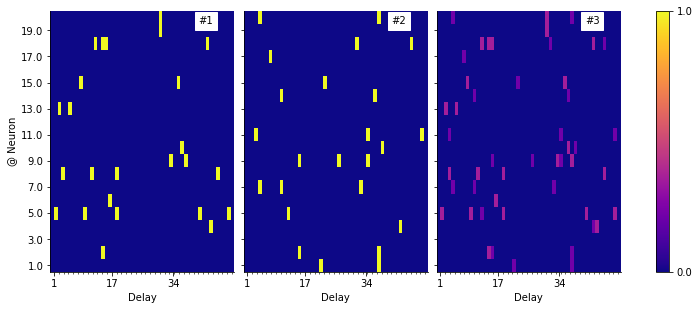

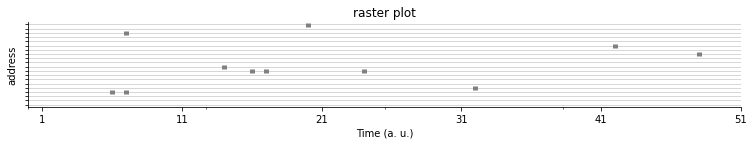

In [17]:
plot_SM(world.kernels, N_show = world.kernels.shape[0], figsize = (12, 5));
plot_raster(input_rp, colored=False);

### Format the ouput for SpikeShip

In [ ]:
N_trials = 10
N_coef_changes = 500
normalize_coef = True
input_rp, labels, S_dist = make_input_and_plot_sdist(world, N_trials=N_trials, N_coef_changes=N_coef_changes, normalize_coef=normalize_coef)

## Manifold learning
### Multidimensionnal scaling

**From sklearn :** Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

In general, MDS is a technique used for analyzing similarity or dissimilarity data. It attempts to model similarity or dissimilarity data as distances in a geometric spaces. The data can be ratings of similarity between objects, interaction frequencies of molecules, or trade indices between countries.

There exists two types of MDS algorithm: metric and non metric. In scikit-learn, the class MDS implements both. In Metric MDS, the input similarity matrix arises from a metric (and thus respects the triangular inequality), the distances between output two points are then set to be as close as possible to the similarity or dissimilarity data. In the non-metric version, the algorithms will try to preserve the order of the distances, and hence seek for a monotonic relationship between the distances in the embedded space and the similarities/dissimilarities. 

In [ ]:
number_of_components = len(world.add_coef)-1
colors = ['r', 'g', 'b']
print(f'expected number of components : {number_of_components}')

Because we normalize the sum of mixture coefficients to be equal to 1, the problem can be solved with 2 components and we get a better visualization. 

In [ ]:
%%time
input_flatten = input_rp.flatten(start_dim=1)
pca_embedding = PCA(n_components=number_of_components).fit_transform(input_flatten)

In [ ]:
plot_embedding(pca_embedding, labels, 'PCA')

PCA seems to solve the separation problem, each dot color is a function of the mixture coefficients that provide the RGB values. Then, each sample is represented as a mixture of the 3 main motifs (red, green, blue)

In [ ]:
kpca_embedding = KernelPCA(n_components=number_of_components, kernel='precomputed').fit_transform(S_dist)
plot_embedding(kpca_embedding, labels, 'kPCA')

In [ ]:
%%time
#input_flatten = input_rp.flatten(start_dim=1)
pca_embedding = PCA(n_components=number_of_components).fit_transform(S_dist)
plot_embedding(pca_embedding, labels, 'PCA')

We obtain the same results with Kernel PCA on the dissimilarity matrix obtained with SpikeShip. As PCA seems to efficiently solve the problem, SpikeShip may be an appropriate kernel for this task. Careful with the condition that the feature space should be an inner product space (check if conditions are satisfied)

## Trying to retrieve the spiking patterns
### For PCA

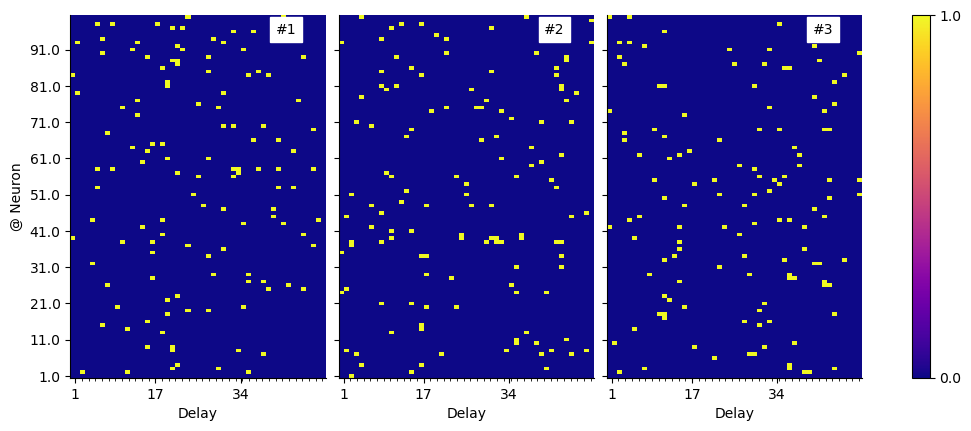

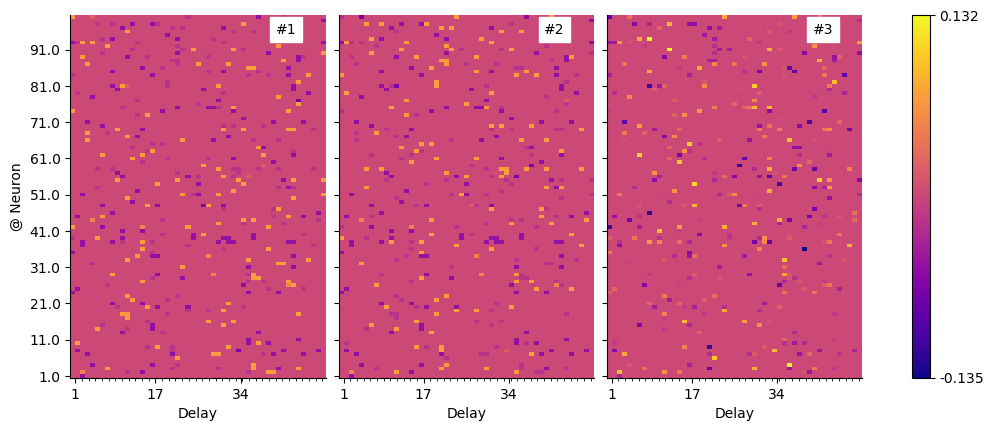

In [13]:
number_of_components=3
pca = PCA(n_components=number_of_components)
pca.fit(input_flatten)
estimated_kernels = pca.components_
estimated_sms = estimated_kernels.reshape((number_of_components, world.kernels.shape[1], world.kernels.shape[2]))
plot_SM(world.kernels, N_show = number_of_components, figsize = (12, 5));
plot_SM(torch.tensor(estimated_sms), N_show = number_of_components, figsize = (12, 5));

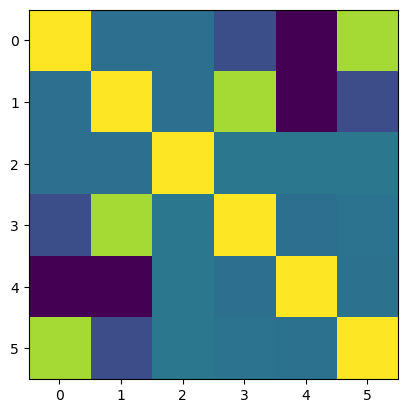

In [14]:
plt.imshow(torch.corrcoef(torch.vstack([torch.tensor(estimated_sms).flatten(start_dim=1), world.kernels[:-1,:,:].flatten(start_dim=1)])));

## For non normalized coef

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2010/2010 [00:10<00:00, 195.36it/s]


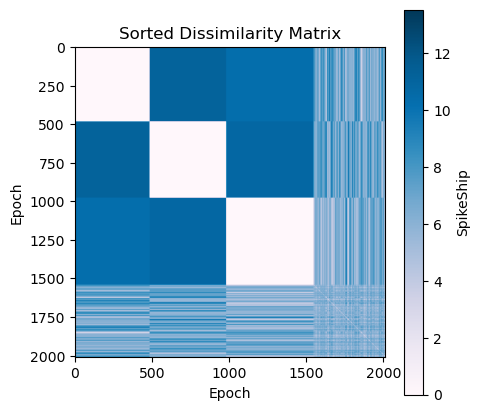

In [15]:
number_of_components=3
normalize_coef = False
input_rp, labels, S_dist = make_input_and_plot_sdist(world, N_trials=N_trials, N_coef_changes=N_coef_changes, normalize_coef=normalize_coef)

In [16]:
input_flatten = input_rp.flatten(start_dim=1)
pca_embedding = PCA(n_components=number_of_components).fit_transform(input_flatten)

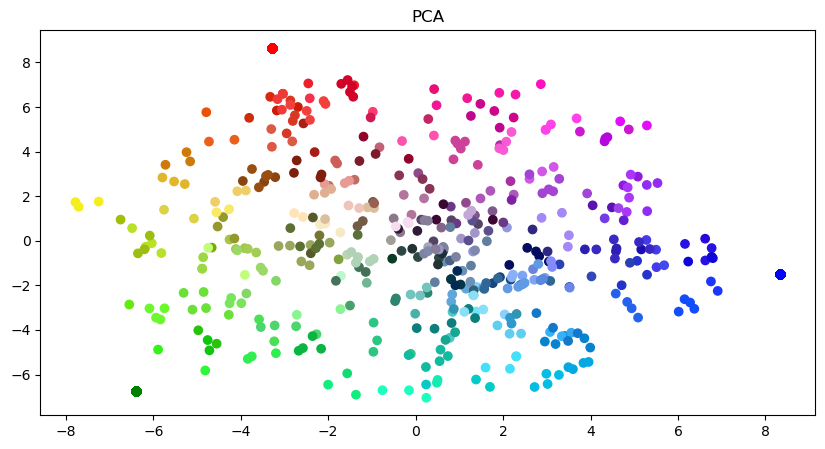

In [17]:
plot_embedding(pca_embedding, labels, 'PCA')

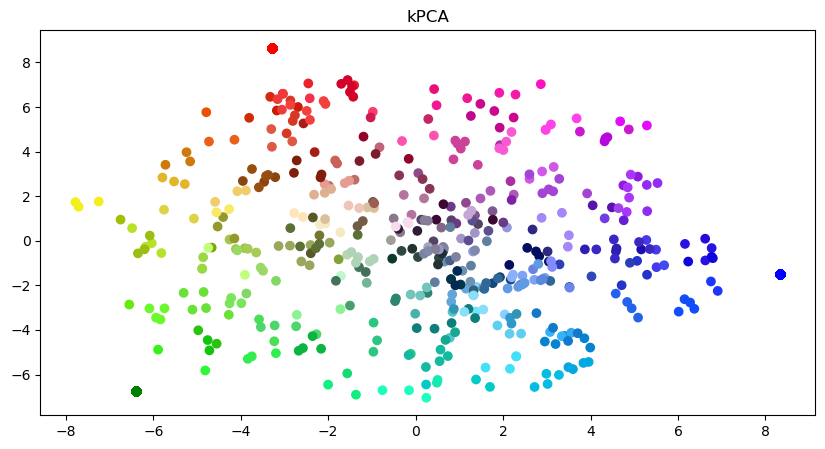

In [18]:
kpca_embedding = KernelPCA(n_components=number_of_components, kernel='precomputed').fit_transform(S_dist)
plot_embedding(pca_embedding, labels, 'kPCA')

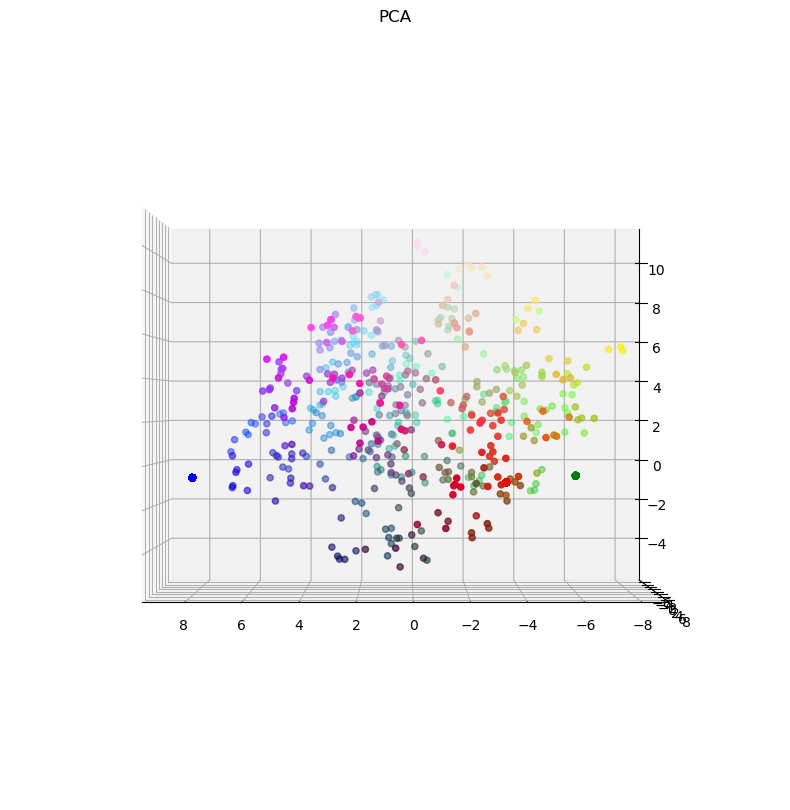

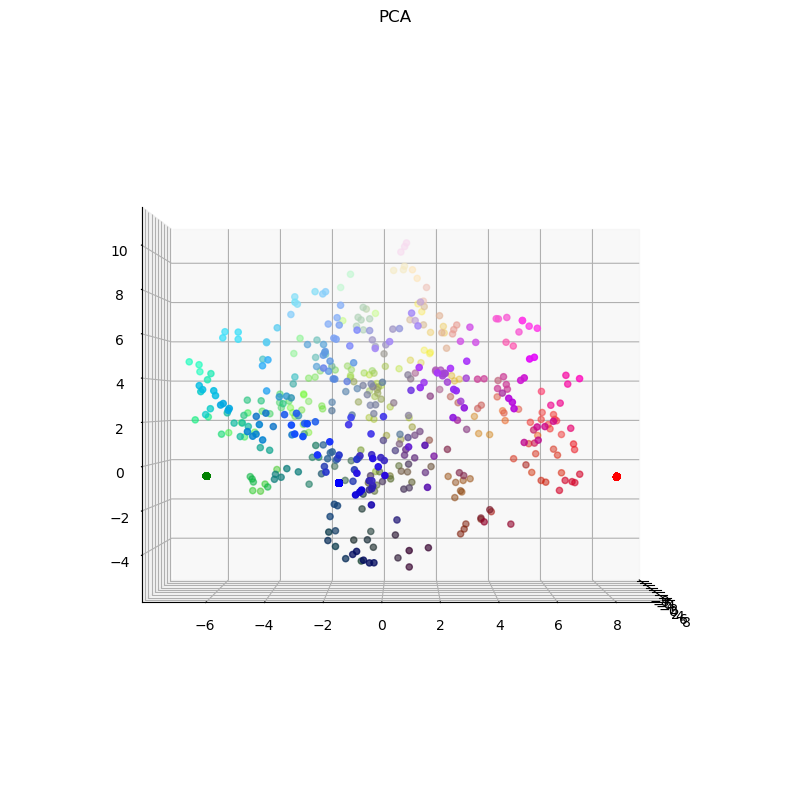

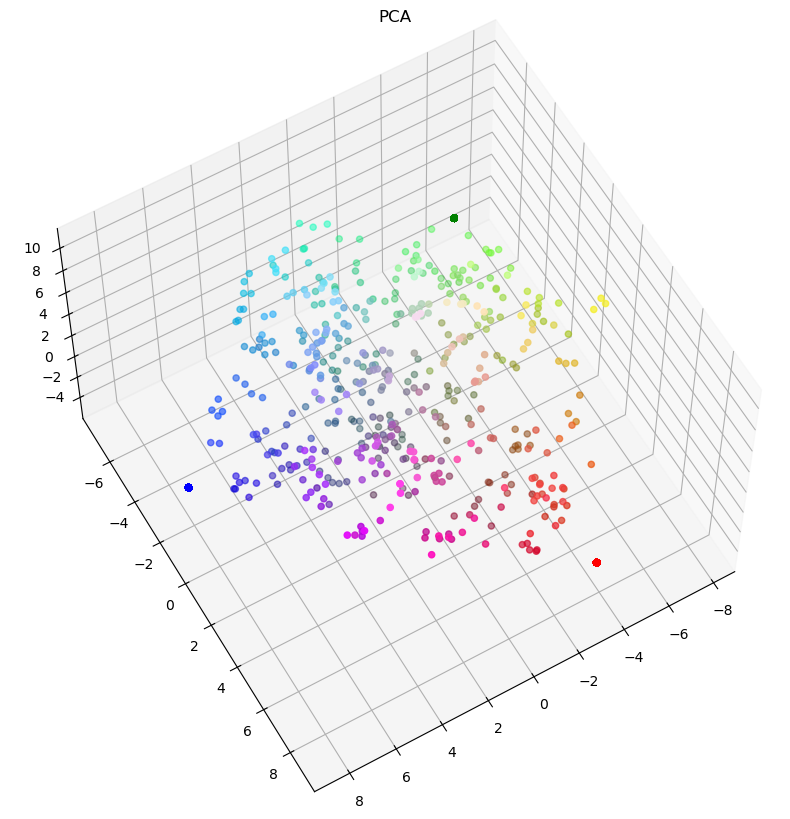

In [19]:
view_init = [0,90]
plot_3d_embedding(pca_embedding, labels, 'PCA', view_init=view_init)
view_init = [0,0]
plot_3d_embedding(pca_embedding, labels, 'PCA', view_init=view_init)
view_init = [60,60]
plot_3d_embedding(pca_embedding, labels, 'PCA', view_init=view_init)

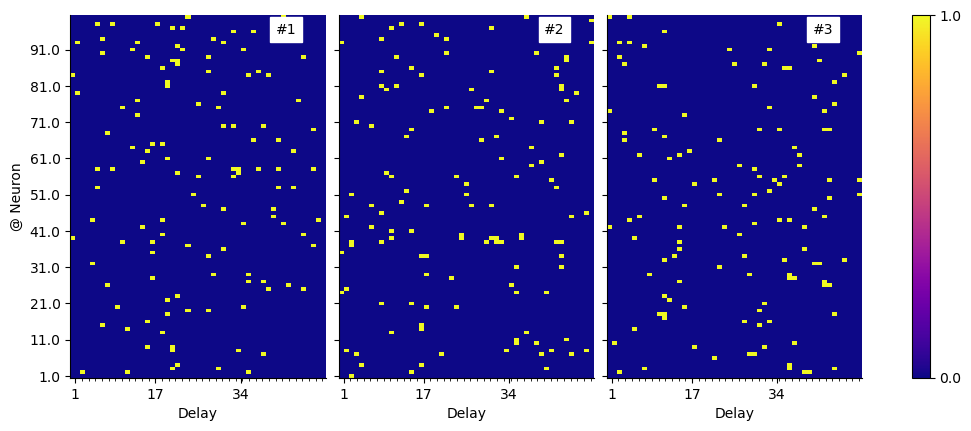

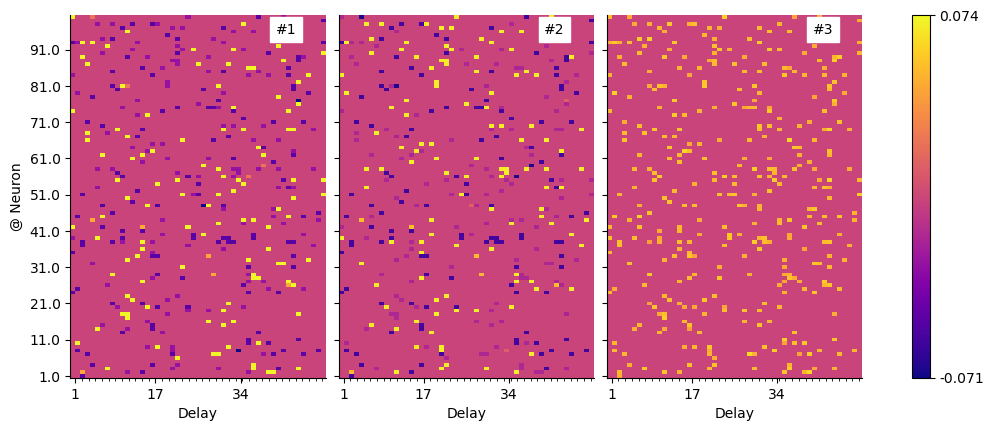

In [20]:
number_of_components=3
pca = PCA(n_components=number_of_components)
pca.fit(input_flatten)
estimated_kernels = pca.components_
estimated_sms = estimated_kernels.reshape((number_of_components, world.kernels.shape[1], world.kernels.shape[2]))
plot_SM(world.kernels, N_show = number_of_components, figsize = (12, 5));
plot_SM(torch.tensor(estimated_sms), N_show = number_of_components, figsize = (12, 5));

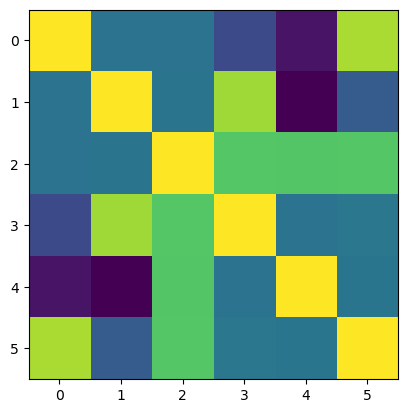

In [21]:
plt.imshow(torch.corrcoef(torch.vstack([torch.tensor(estimated_sms).flatten(start_dim=1), world.kernels[:-1,:,:].flatten(start_dim=1)])));

## Mixture with 4 motifs

In [22]:
class world_params:
    N_pre = 100 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 4 # number of SM used for RP generation

    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM

    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP

    avg_precision = 2 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision

    seed = 4815162342 # seed

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2010/2010 [00:09<00:00, 212.30it/s]


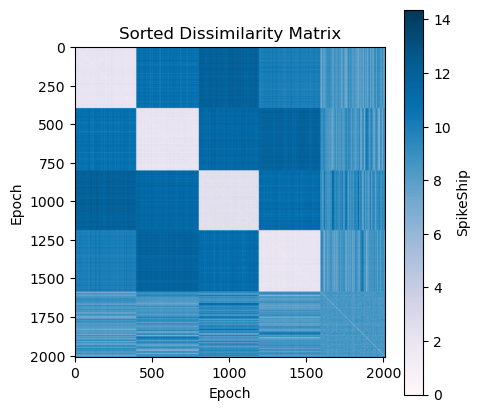

In [23]:
opt = world_params()
world = SM_World(opt, add_coef = None)

normalize_coef = True
input_rp, labels, S_dist = make_input_and_plot_sdist(world, N_trials=N_trials, N_coef_changes=N_coef_changes, normalize_coef=normalize_coef)

In [24]:
number_of_components = 3#len(world.add_coef)-1
print(f'expected number of components : {number_of_components}')

expected number of components : 3


In [25]:
input_flatten = input_rp.flatten(start_dim=1)
pca_embedding = PCA(n_components=number_of_components).fit_transform(S_dist)# metric=True, normalized_stress='auto')

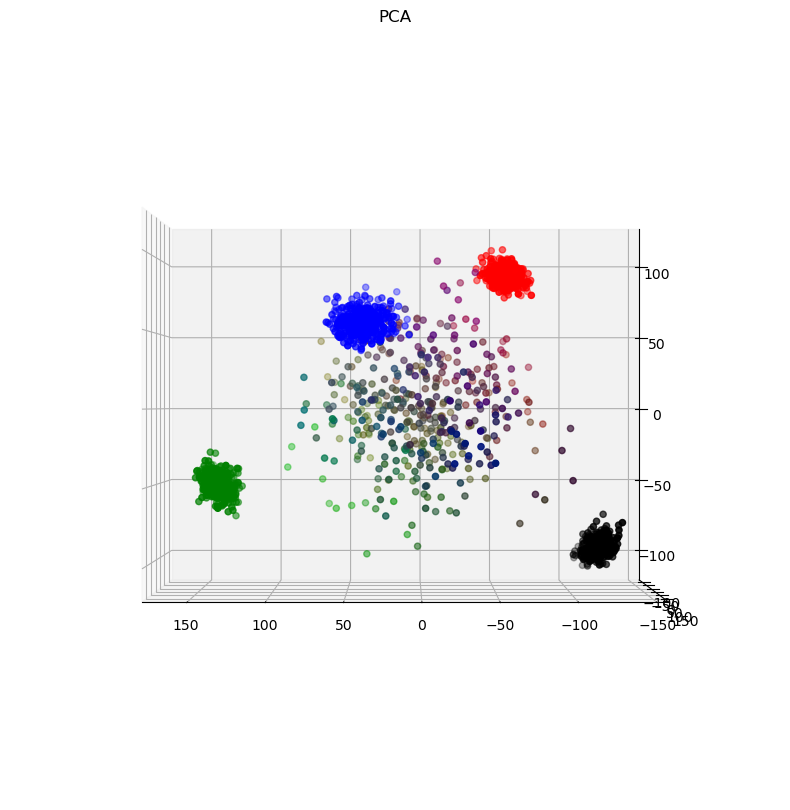

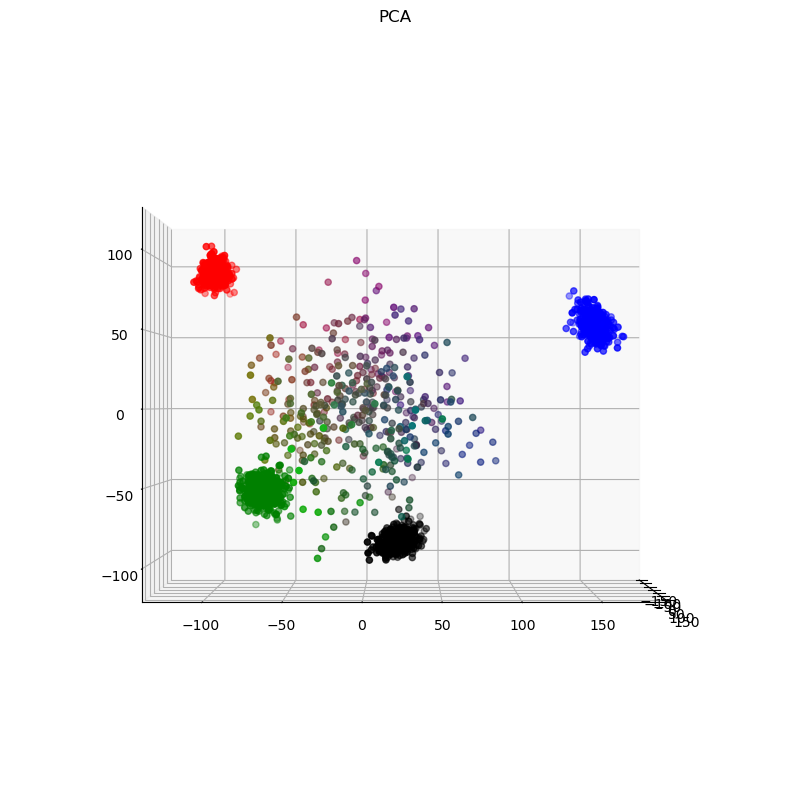

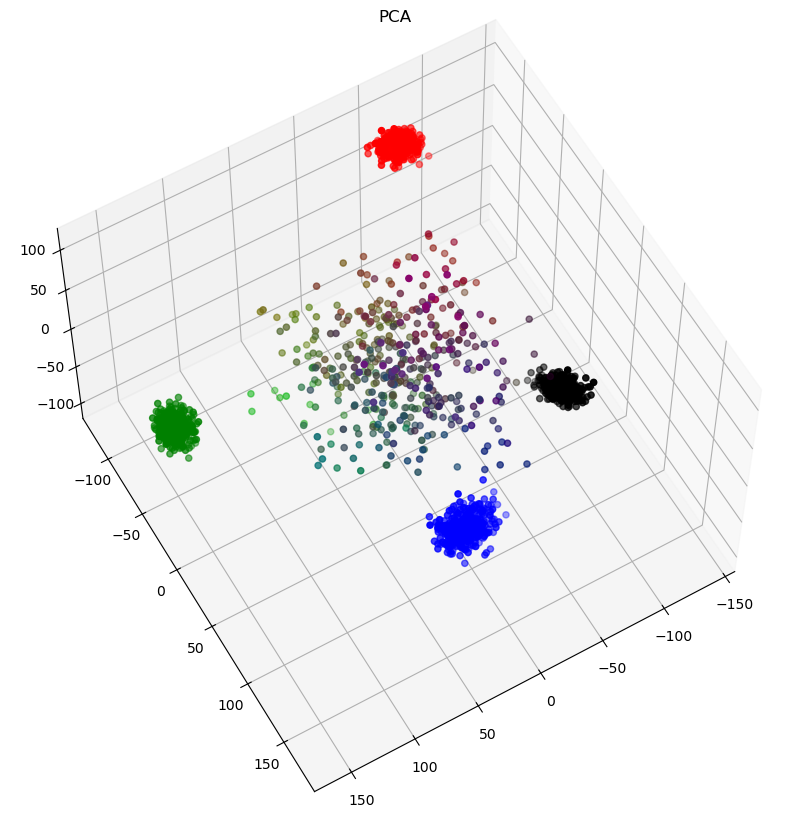

In [26]:
colors = ['r', 'g', 'b', 'black']
view_init = [0,90]
plot_3d_embedding(pca_embedding, labels, 'PCA', colors=colors, view_init=view_init)
view_init = [0,0]
plot_3d_embedding(pca_embedding, labels, 'PCA', colors=colors, view_init=view_init)
view_init = [60,60]
plot_3d_embedding(pca_embedding, labels, 'PCA', colors=colors, view_init=view_init)

In [27]:
number_of_components = 2#len(world.add_coef)-1
print(f'expected number of components : {number_of_components}')

pca_embedding = PCA(n_components=number_of_components).fit_transform(S_dist)# metric=True, normalized_stress='auto')

expected number of components : 2


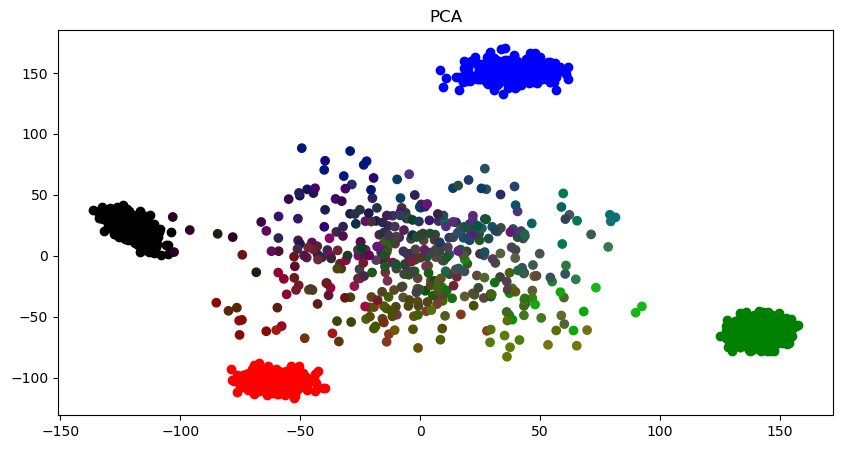

In [28]:
plot_embedding(pca_embedding, labels, 'PCA', colors=colors)

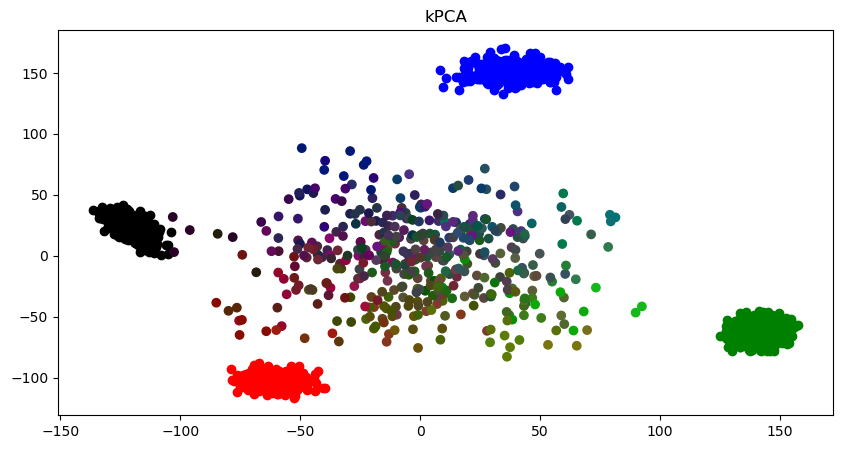

In [29]:
kpca_embedding = KernelPCA(n_components=number_of_components, kernel='precomputed').fit_transform(S_dist)
plot_embedding(pca_embedding, labels, 'kPCA', colors=colors)